# Capstone Project - The Battle Of Neighborhoods - Finding Better Place in Cheap Price for opening an Indian restaurant

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Result](#result)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Birmingham is a major city in England’s West Midlands region, with multiple Industrial Revolution-era landmarks that speak to its 18th-century history as a manufacturing powerhouse.

In this project we will try to find an optimal location for an Indian restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Indian Restaurant** in **Birmingham**, England, United Kingdom.

Since there are lots of restaurants in Birmingham we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no indian restaurants in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Indian restaurants in the neighborhood, if any

We decided to use regularly spaced grid of locations, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* Neighborhoods will be generated algorithmically and approximate addresses of boroughs  will be obtained using **https://en.wikipedia.org/wiki/B_postcode_area**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Birmingham  will be obtained using **CSV File:postcode-outcodes.csv**.

### Import Libraries

In [234]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## Data Extraction and Cleaning

Using BeautifulSoup Scraping List of Postal Codes of Birmingham, England, United kingdom. Link : https://en.wikipedia.org/wiki/B_postcode_area

In [235]:
import requests
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/B_postcode_area"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [236]:
from bs4 import BeautifulSoup
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
birminghamtable=soup.find('table',{'class':"wikitable"})

Converting content of PostalCode HTML table as dataframe

In [237]:
import pandas as pd # library for data analsysis
df=pd.read_html(str(birminghamtable))
# convert list to dataframe
df=pd.DataFrame(df[0])
df.head()

,Postcode district,Post town,Coverage,Local authority area(s)
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",Birmingham
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street",Birmingham
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street",Birmingham
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",Birmingham
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",Birmingham


In [238]:
df.rename(columns={"Postcode district": "PostalCode"}, inplace=True)
df.head()

,PostalCode,Post town,Coverage,Local authority area(s)
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",Birmingham
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street",Birmingham
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street",Birmingham
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",Birmingham
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",Birmingham


In [239]:
df.rename(columns={"Coverage": "Neighborhood"}, inplace=True)
df.head()

,PostalCode,Post town,Neighborhood,Local authority area(s)
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",Birmingham
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street",Birmingham
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street",Birmingham
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",Birmingham
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",Birmingham


In [240]:
df.rename(columns={"Local authority area(s)": "Borough"}, inplace=True)
df.head()

,PostalCode,Post town,Neighborhood,Borough
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",Birmingham
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street",Birmingham
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street",Birmingham
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",Birmingham
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",Birmingham


In [241]:
df = df.reindex(columns=['PostalCode', 'Post town', 'Borough', 'Neighborhood'])
df.head()

,PostalCode,Post town,Borough,Neighborhood
0,B1,BIRMINGHAM,Birmingham,"Birmingham City Centre, Broad Street (east)"
1,B2,BIRMINGHAM,Birmingham,"Birmingham City Centre, New Street"
2,B3,BIRMINGHAM,Birmingham,"Birmingham City Centre, Newhall Street"
3,B4,BIRMINGHAM,Birmingham,"Birmingham City Centre, Corporation Street (no..."
4,B5,BIRMINGHAM,Birmingham,"Digbeth, Highgate, Lee Bank"


In [242]:
# drop cells with a borough that is Not assigned
df_drop = df.drop(columns="Post town")
df_drop.head()

,PostalCode,Borough,Neighborhood
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)"
1,B2,Birmingham,"Birmingham City Centre, New Street"
2,B3,Birmingham,"Birmingham City Centre, Newhall Street"
3,B4,Birmingham,"Birmingham City Centre, Corporation Street (no..."
4,B5,Birmingham,"Digbeth, Highgate, Lee Bank"


In [243]:
# create a new test dataframe

column_names = ["PostalCode", "Borough", "Neighborhood"]
birmingham_df = pd.DataFrame(columns=column_names)
birmingham_list = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B10", "B11", "B12", "B13", "B14", "B15", "B16", "B17", "B19", "B20",
                   "B21", "B22", "B23", "B24", "B25", "B26", "B27", "B28", "B29", "B30", "B31", "B32", "B33", "B34", "B35", "B36", "B37", "B38",
                   "B40", "B42", "B43", "B44", "B45", "B46", "B47", "B48", "B49", "B50", "B60", "B61", "B62", "B63", "B64", "B65", "B66", "B67", 
                   "B68", "B69", "B70", "B71", "B72", "B73", "B74", "B78", "B79", "B80", "B90", "B91", "B92", "B93", "B94", "B95", "B96", "B97" , 
                   "B98"]

for postcode in birmingham_list:
    birmingham_df = birmingham_df.append(df_drop[df_drop["PostalCode"]==postcode], ignore_index=True)
    
birmingham_df

,PostalCode,Borough,Neighborhood
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)"
1,B2,Birmingham,"Birmingham City Centre, New Street"
2,B3,Birmingham,"Birmingham City Centre, Newhall Street"
3,B4,Birmingham,"Birmingham City Centre, Corporation Street (no..."
4,B5,Birmingham,"Digbeth, Highgate, Lee Bank"
5,B6,Birmingham,"Aston, Birchfield, Birmingham , Witton"
6,B7,Birmingham,"Nechells, Vauxhall"
7,B8,Birmingham,"Washwood Heath, Ward End, Saltley"
8,B9,Birmingham,"Bordesley Green, Bordesley"
9,B10,Birmingham,Small Heath


In [244]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Birmingham, United Kingdom'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('B91')

[52.47891000000004, -1.9059199999999805]

In [245]:
from geopy.geocoders import Nominatim 
locator = Nominatim(user_agent="JupyterLab")
location = locator.geocode("Solihull, Birmingham, United Kingdom")

In [246]:
print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 52.471105949999995, Longitude = -1.846180941301216


## Load the coordinates from the csv file

In [247]:
# load the coordinates from the csv file on Coursera
import pandas as pd # library for data analsysis
coordinates = pd.read_csv(r"C:\Users\tanay\Documents\Coursera\postcode-outcodes.csv")
coordinates.head()

,PostalCode,latitude,longitude
0,B1,52.47872,-1.90723
1,B2,52.47871,-1.89692
2,B3,52.48051,-1.90134
3,B4,52.48231,-1.89397
4,B5,52.46972,-1.89547


In [248]:
# merge two table on the column "PostalCode"
df_new = birmingham_df.merge(coordinates, on="PostalCode", how="left")
df_new

,PostalCode,Borough,Neighborhood,latitude,longitude
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",52.47872,-1.90723
1,B2,Birmingham,"Birmingham City Centre, New Street",52.47871,-1.89692
2,B3,Birmingham,"Birmingham City Centre, Newhall Street",52.48051,-1.90134
3,B4,Birmingham,"Birmingham City Centre, Corporation Street (no...",52.48231,-1.89397
4,B5,Birmingham,"Digbeth, Highgate, Lee Bank",52.46972,-1.89547
5,B6,Birmingham,"Aston, Birchfield, Birmingham , Witton",52.50388,-1.88508
6,B7,Birmingham,"Nechells, Vauxhall",52.49307,-1.87185
7,B8,Birmingham,"Washwood Heath, Ward End, Saltley",52.49034,-1.84092
8,B9,Birmingham,"Bordesley Green, Bordesley",52.47776,-1.84833
9,B10,Birmingham,Small Heath,52.46967,-1.85130


In [249]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Birmingham'
geolocator = Nominatim(user_agent="JupyterLab")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Birmingham are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Birmingham are 52.4796992, -1.9026911.


## Map of Birmingham

In [250]:
import folium # map rendering library
# create map of Birmingham using latitude and longitude values
map_birmingham = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_new['latitude'], df_new['longitude'], df_new['Borough'], df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_birmingham)  
    
map_birmingham

## Use the Foursquare API to explore the Neighborhoods

In [251]:
# define Foursquare Credentials and Version
CLIENT_ID = 'W5UHQS1XM1K1TWRR5NNFSXSC1MR3SNB0S5F03E4IL13FNXFP' # your Foursquare ID
CLIENT_SECRET = '35RVKTDGMQUC0HWROJ4CCSVPXIC2UMKKVCBUHO5X5LU5UINR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: W5UHQS1XM1K1TWRR5NNFSXSC1MR3SNB0S5F03E4IL13FNXFP
CLIENT_SECRET:35RVKTDGMQUC0HWROJ4CCSVPXIC2UMKKVCBUHO5X5LU5UINR


## Get the top 100 venues that are within a radius of 500 meters

In [252]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])
                    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [253]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(629, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",52.47872,-1.90723,Symphony Hall,52.478874,-1.910229,Concert Hall
1,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",52.47872,-1.90723,Hyatt Regency Birmingham,52.478096,-1.909324,Hotel
2,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",52.47872,-1.90723,Dishoom,52.480323,-1.904520,Indian Restaurant
3,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",52.47872,-1.90723,The Rep Theatre,52.479108,-1.909016,Theater
4,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",52.47872,-1.90723,Birmingham Town Hall,52.479509,-1.903560,Concert Hall


### Venues that were returned for each PostalCode

In [254]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhood,,,,,,
B1,Birmingham,"Birmingham City Centre, Broad Street (east)",100,100,100,100,100,100
B10,Birmingham,Small Heath,5,5,5,5,5,5
B11,Birmingham,"Sparkhill, Sparkbrook, Tyseley",5,5,5,5,5,5
B12,Birmingham,"Balsall Heath, Sparkbrook, Highgate",10,10,10,10,10,10
B13,Birmingham,"Moseley, Billesley",1,1,1,1,1,1
B14,Birmingham,"Kings Heath, Yardley Wood, Druids Heath, Highter's Heath, Warstock",4,4,4,4,4,4
B15,Birmingham,"Edgbaston,",7,7,7,7,7,7
B16,Birmingham,Ladywood,9,9,9,9,9,9
B17,Birmingham,"Harborne, Edgbaston",5,5,5,5,5,5


### Unique categories that can be curated from all the returned Venues

In [255]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 150 uniques categories.


In [256]:
venues_df['VenueCategory'].unique()[:50]

array(['Concert Hall', 'Hotel', 'Indian Restaurant', 'Theater',
       'History Museum', 'Trail', 'Bar', 'Restaurant', 'Pub', 'Canal',
       'Plaza', 'French Restaurant', 'Shopping Plaza', 'Garden',
       'Harbor / Marina', 'Beer Bar', 'Department Store', 'Movie Theater',
       'Coffee Shop', 'Cocktail Bar', 'South American Restaurant',
       'Pie Shop', 'Tea Room', 'Bakery', 'Convention Center',
       'Gourmet Shop', 'Greek Restaurant', 'Pizza Place',
       'Pedestrian Plaza', 'Art Gallery', 'Fried Chicken Joint',
       'Burger Joint', 'Tapas Restaurant', 'Caribbean Restaurant',
       'Sandwich Place', 'Café', 'Shopping Mall', 'Steakhouse',
       'Aquarium', 'English Restaurant', 'Salon / Barbershop',
       'Italian Restaurant', 'Fountain', 'Brazilian Restaurant',
       'Chinese Restaurant', 'Dim Sum Restaurant', 'Bubble Tea Shop',
       'BBQ Joint', 'Pharmacy', 'Hookah Bar'], dtype=object)

### Analyze Each Area

In [257]:
# one hot encoding
birmingham_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
birmingham_onehot['PostalCode'] = venues_df['PostalCode'] 
birmingham_onehot['Borough'] = venues_df['Borough'] 
birmingham_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(birmingham_onehot.columns[-3:]) + list(birmingham_onehot.columns[:-3])
birmingham_onehot = birmingham_onehot[fixed_columns]

print(birmingham_onehot.shape)
birmingham_onehot.head()

(629, 153)


,PostalCode,Borough,Neighborhoods,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Bookstore,Botanical Garden,Bowling Alley,Brazilian Restaurant,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Canal,Caribbean Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Electronics Store,English Restaurant,Entertainment Service,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,History Museum,Home Service,Hookah Bar,Hotel,IT Services,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Light Rail Station,Lounge,Market,Massage Studio,Miscellaneous Shop,Moroccan Restaurant,Movie Theater,Music Venue,Nature Preserve,Neighborhood,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Real Estate Office,Record Shop,Reservoir,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Shopping Mall,Shopping Plaza,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Waterfall,Wine Shop,Women's Store,Yoga Studio
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [258]:
birmingham_grouped = birmingham_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(birmingham_grouped.shape)
birmingham_grouped

(68, 153)


,PostalCode,Borough,Neighborhoods,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Bookstore,Botanical Garden,Bowling Alley,Brazilian Restaurant,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Campground,Canal,Caribbean Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant,Donut Shop,Dry Cleaner,Electronics Store,English Restaurant,Entertainment Service,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flower Shop,Food,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,History Museum,Home Service,Hookah Bar,Hotel,IT Services,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Light Rail Station,Lounge,Market,Massage Studio,Miscellaneous Shop,Moroccan Restaurant,Movie Theater,Music Venue,Nature Preserve,Neighborhood,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Real Estate Office,Record Shop,Reservoir,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Shopping Mall,Shopping Plaza,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Waterfall,Wine Shop,Women's Store,Yoga Studio
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",0.000000,0.01,0.02,0.0,0.000000,0.00,0.000000,0.01,0.01,0.050000,0.020000,0.000,0.000000,0.000000,0.000000,0.01,0.01,0.020000,0.000000,0.0,0.0,0.030000,0.00,0.01,0.010000,0.010000,0.010000,0.000000,0.000000,0.050000,0.070000,0.030000,0.000000,0.000000,0.01,0.000000,0.0,0.010000,0.000000,0.01,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.01,0.000000,0.000000,0.000000,0.000,0.00,0.0,0.01,0.02,0.010000,0.000000,0.000000,0.010000,0.000,0.000000,0.000000,0.00,0.00,0.01,0.01,0.010000,0.010000,0.000000,0.000000,0.01,0.000000,0.0,0.010000,0.0,0.01,0.040000,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.000000,0.0,0.010000,0.000000,0.00,0.00,0.0,0.00,0.000000,0.01,0.000000,0.000000,0.010000,0.00,0.01,0.030000,0.000000,0.0,0.030000,0.000000,0.0,0.010000,0.0,0.040000,0.00,0.000000,0.000000,0.020000,0.000000,0.01,0.040000,0.020000,0.010000,0.000000,0.000000,0.010000,0.0,0.0,0.000000,0.0,0.000000,0.02,0.000000,0.000000,0.010000,0.010000,0.010000,0.000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,B10,Birmingham,Small Heath,0.000000,0.00,0.00,0.0,0.200000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.0,0.200000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.200000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0000

## New dataframe displaying the top 10 Venues for each PostalCode

In [259]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = birmingham_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = birmingham_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = birmingham_grouped['Neighborhoods']

for ind in np.arange(birmingham_grouped.shape[0]):
    row_categories = birmingham_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(68, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",Coffee Shop,Indian Restaurant,Cocktail Bar,Bar,Pub,Italian Restaurant,Sandwich Place,Hotel,Café,Concert Hall
1,B10,Birmingham,Small Heath,Café,Asian Restaurant,Gym / Fitness Center,Turkish Restaurant,Sandwich Place,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
2,B11,Birmingham,"Sparkhill, Sparkbrook, Tyseley",Park,Pakistani Restaurant,Gas Station,Sandwich Place,Italian Restaurant,Food,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
3,B12,Birmingham,"Balsall Heath, Sparkbrook, Highgate",Indian Restaurant,Fast Food Restaurant,Café,Women's Store,Pool,Grocery Store,Moroccan Restaurant,Pakistani Restaurant,Entertainment Service,Food
4,B13,Birmingham,"Moseley, Billesley",Convenience Store,Yoga Studio,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
5,B14,Birmingham,"Kings Heath, Yardley Wood, Druids Heath, Hight...",Restaurant,Gym / Fitness Center,Grocery Store,Chinese Restaurant,Electronics Store,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
6,B15,Birmingham,"Edgbaston,",Pizza Place,Gastropub,Hotel,Pub,Coffee Shop,Botanical Garden,Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
7,B16,Birmingham,Ladywood,Fast Food Restaurant,Casino,Convenience Store,Grocery Store,Sandwich Place,Insurance Office,Persian Restaurant,Chinese Restaurant,Reservoir,Yoga Studio
8,B17,Birmingham,"Harborne, Edgbaston",Deli / Bodega,Gym / Fitness Center,Coffee Shop,Bakery,Bar,Donut Shop,Doner Restaurant,Dry Cleaner,Electronics Store,Discount Store
9,B19,Birmingham,"Lozells, Newtown, Birchfield",Soccer Field,Soccer Stadium,Yoga Studio,English Restaurant,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,Electronics Store


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Birmingham that have low restaurant density, particularly those with low number of Indian restaurants. We will limit our analysis to area ~500m.

In first step we have collected the required **data: location and type (category) of every restaurant within 500m from Birmingham** . 

Second step in our analysis will be focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

### Find the optimal k value for clustering and we do it using the elbow method

In [260]:
birmingham_grouped_count = birmingham_onehot.groupby(['Borough','Neighborhoods'])['Borough'].count().to_frame()
birmingham_grouped_count

Borough
Borough                        Neighborhoods                                              
Birmingham                     Acocks Green                                             11
                               Aston, Birchfield, Birmingham , Witton                    4
                               Balsall Heath, Sparkbrook, Highgate                      10
                               Birmingham City Centre, Broad Street (east)             100
                               Birmingham City Centre, Corporation Street (north)       49
                               Birmingham City Centre, New Street                       70
                               Birmingham City Centre, Newhall Street                   57
                               Boldmere, New Oscott, Wylde Green                        10
                               Bordesley Green, Bordesley                                2
                               Bournville, Cotteridge, Stirchley                         5
                               Castle Vale                                               4
                               Digbeth, Highgate, Lee Bank                              24
                               Edgbaston,                                                7
                               Erdington, Stockland Green, Short Heath, Perry ...        4
                               Erdington, Wylde Green, Tyburn                            2
                               Hall Green                                                5
                               Handsworth                                                5
                               Handsworth Wood, Handsworth, Birchfield                   2
                               Harborne, Edgbaston                                       5
                               Kings Heath, Yardley Wood, Druids Heath, Highte...        4
                               Kings Norton, West Heath                                  1
                               Kitts Green, Stechford                                    4
                               Ladywood                                                  9
                               Lozells, Newtown, Birchfield                              3
                               Moseley, Billesley                                        1
                               Nechells, Vauxhall                                        4
                               Northfield, Longbridge, West Heath                        3
                               Perry Barr, Great Barr, Hamstead                          4
                               Perry Barr, Kingstanding, Great Barr                      4
                               Selly Oak, Bournbrook, Selly Park, Weoley Castl...        2
                               Shard End, Buckland End                                   3
                               Sheldon, Yardley                                          4
                               Small Heath                                               5
                               Sparkhill, Sparkbrook, Tyseley                            5
                               Sutton Coldfield town centre, Maney, Wylde Gree...        2
                               Washwood Heath, Ward End, Saltley                         2
                               Yardley                                                   4
Birmingham, Bromsgrove         Rednal, New Frankley, Rubery, Cofton Hackett, B...        4
Birmingham, Lichfield, Walsall Four Oaks, Mere Green, Little Aston, Streetly             1
Birmingham, Sandwell           Rowley Regis, Blackheath                                  6
Birmingham, Sandwell, Walsall  Great Barr, Hamstead                                      6
Birmingham, Solihull           Castle Bromwich, Smith's Wood, Bromford, Hodge ...        4
Bromsgrove                     Bromsgrove (east)                               

In [261]:
birmingham_grouped_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)
birmingham_grouped_count.reset_index(inplace=True)
birmingham_grouped_count

,Borough,Neighborhoods,NumberOfVenues
0,Birmingham,Acocks Green,11
1,Birmingham,"Aston, Birchfield, Birmingham , Witton",4
2,Birmingham,"Balsall Heath, Sparkbrook, Highgate",10
3,Birmingham,"Birmingham City Centre, Broad Street (east)",100
4,Birmingham,"Birmingham City Centre, Corporation Street (no...",49
5,Birmingham,"Birmingham City Centre, New Street",70
6,Birmingham,"Birmingham City Centre, Newhall Street",57
7,Birmingham,"Boldmere, New Oscott, Wylde Green",10
8,Birmingham,"Bordesley Green, Bordesley",2
9,Birmingham,"Bournville, Cotteridge, Stirchley",5


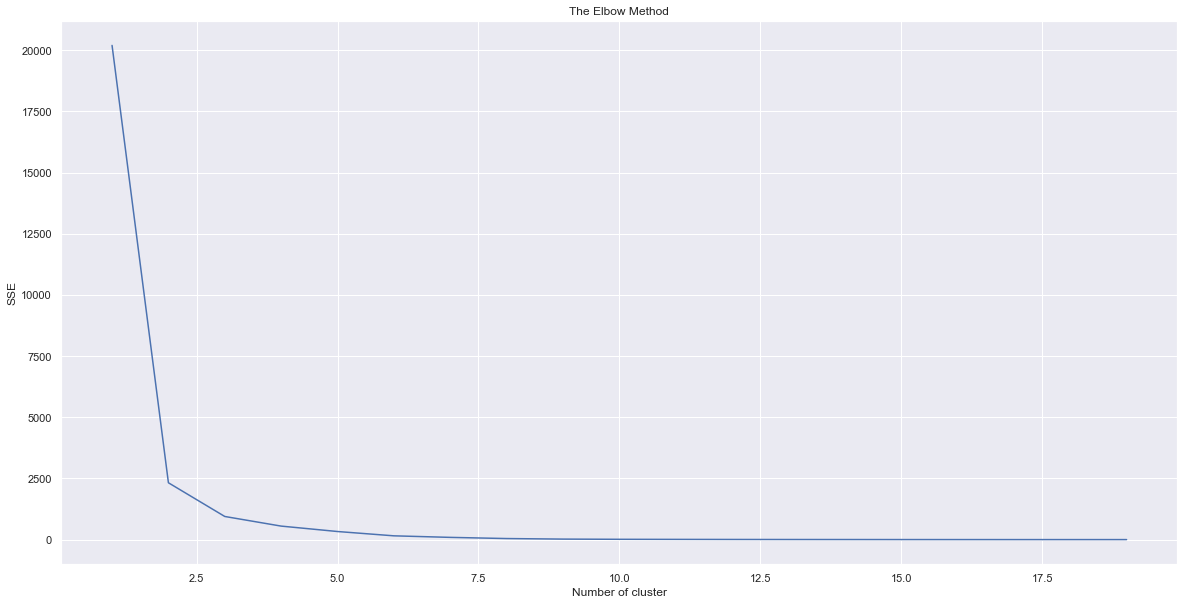

In [262]:
sse = {}
for k in range(1,20):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(birmingham_grouped_count.drop('Neighborhoods',axis=1).drop('Borough',axis=1))
    birmingham_grouped["Cluster Labels"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(20,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('The Elbow Method')
plt.show()

From the above graph, we can see the **optimal value** for **cluster** is **5**.

## Cluster Areas

### Run k-means to cluster the Toronto areas into 5 clusters.

In [263]:
# set number of clusters

kmeans = KMeans(n_clusters=5)
birmingham_grouped_clustering = birmingham_grouped.drop(["PostalCode", "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters= 5, random_state=0).fit(birmingham_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:16]

array([1, 0, 1, 0, 3, 3, 0, 1, 3, 1, 0, 3, 2, 0, 3, 1])

In [264]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans()
X = np.random.rand(73, 5)
kmeans.fit(X)
print(kmeans.labels_)

[2 6 0 7 2 4 7 7 5 3 1 3 0 7 6 0 7 2 0 4 7 3 7 1 3 5 5 7 6 2 6 5 2 0 0 7 2
 5 6 1 7 4 0 1 1 7 2 6 4 6 4 5 5 2 3 5 0 2 0 1 5 1 3 3 5 1 5 5 0 2 3 6 7]


In [265]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
birmingham_merged = df_new.copy()

birmingham_merged["Cluster Labels"] = kmeans.labels_


# merge birmingham_grouped with birmingham_data to add latitude/longitude for each neighborhood
birmingham_merged = birmingham_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")

print(birmingham_merged.shape)
birmingham_merged.head() # check the last columns!

(73, 16)


,PostalCode,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,B1,Birmingham,"Birmingham City Centre, Broad Street (east)",52.47872,-1.90723,2,Coffee Shop,Indian Restaurant,Cocktail Bar,Bar,Pub,Italian Restaurant,Sandwich Place,Hotel,Café,Concert Hall
1,B2,Birmingham,"Birmingham City Centre, New Street",52.47871,-1.89692,6,Coffee Shop,Shopping Mall,Pub,Clothing Store,Burger Joint,Bar,Café,Vegetarian / Vegan Restaurant,Sandwich Place,Indian Restaurant
2,B3,Birmingham,"Birmingham City Centre, Newhall Street",52.48051,-1.90134,0,Coffee Shop,Pub,Indian Restaurant,Hotel,Shopping Mall,Beer Bar,Sandwich Place,Restaurant,Plaza,Bar
3,B4,Birmingham,"Birmingham City Centre, Corporation Street (no...",52.48231,-1.89397,7,Pub,Coffee Shop,Sandwich Place,Hotel,Café,Bar,Burger Joint,Clothing Store,Dessert Shop,Rock Club
4,B5,Birmingham,"Digbeth, Highgate, Lee Bank",52.46972,-1.89547,2,Gay Bar,Chinese Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Farmers Market,Music Venue,Grocery Store,Turkish Restaurant,Auto Garage


### Final Clusters

In [266]:
# sort the results by Cluster Labels
print(birmingham_merged.shape)
birmingham_merged.sort_values(["Cluster Labels"], inplace=True)
birmingham_merged

(73, 16)


,PostalCode,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,B13,Birmingham,"Moseley, Billesley",52.43644,-1.87790,0,Convenience Store,Yoga Studio,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
15,B16,Birmingham,Ladywood,52.47604,-1.93374,0,Fast Food Restaurant,Casino,Convenience Store,Grocery Store,Sandwich Place,Insurance Office,Persian Restaurant,Chinese Restaurant,Reservoir,Yoga Studio
34,B37,Solihull,"Chelmsley Wood, Marston Green, Kingshurst, For...",52.47847,-1.74083,0,Fast Food Restaurant,Hardware Store,Warehouse Store,Discount Store,Shopping Mall,Bar,Yoga Studio,Entertainment Service,Food,Flower Shop
42,B47,Bromsgrove,"Hollywood, Wythall",52.38699,-1.87950,0,Convenience Store,Indian Restaurant,Chinese Restaurant,Yoga Studio,Entertainment Service,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
33,B36,"Birmingham, Solihull","Castle Bromwich, Smith's Wood, Bromford, Hodge...",52.50373,-1.77899,0,English Restaurant,Hotel,Pub,BBQ Joint,Yoga Studio,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
58,B72,Birmingham,"Sutton Coldfield town centre, Maney, Wylde Gre...",52.55145,-1.82153,0,Athletics & Sports,Gym,Yoga Studio,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
56,B70,Sandwell,"West Bromwich (south, west and town centre)",52.52012,-2.00295,0,Pub,Light Rail Station,Indian Restaurant,Supermarket,Yoga Studio,Entertainment Service,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
68,B94,Solihull,"Hockley Heath, Earlswood",52.35090,-1.79150,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B3,Birmingham,"Birmingham City Centre, Newhall Street",52.48051,-1.90134,0,Coffee Shop,Pub,Indian Restaurant,Hotel,Shopping Mall,Beer Bar,Sandwich Place,Restaurant,Plaza,Bar
18,B20,Birmingham,"Handsworth Wood, Handsworth, Birchfield",52.51379,-1.91747,0,Sports Club,Grocery Store,Yoga Studio,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service


## Map of Birmingham with Neighborhoods

In [267]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
n_clusters = 5
# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i+x+(i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(birmingham_merged['latitude'], birmingham_merged['longitude'], birmingham_merged['PostalCode'], birmingham_merged['Borough'], birmingham_merged['Neighborhood'], birmingham_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        fill_color=rainbow[cluster-3],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [268]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 0, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Birmingham,0,Convenience Store,Yoga Studio,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
15,Birmingham,0,Fast Food Restaurant,Casino,Convenience Store,Grocery Store,Sandwich Place,Insurance Office,Persian Restaurant,Chinese Restaurant,Reservoir,Yoga Studio
34,Solihull,0,Fast Food Restaurant,Hardware Store,Warehouse Store,Discount Store,Shopping Mall,Bar,Yoga Studio,Entertainment Service,Food,Flower Shop
42,Bromsgrove,0,Convenience Store,Indian Restaurant,Chinese Restaurant,Yoga Studio,Entertainment Service,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
33,"Birmingham, Solihull",0,English Restaurant,Hotel,Pub,BBQ Joint,Yoga Studio,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
58,Birmingham,0,Athletics & Sports,Gym,Yoga Studio,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
56,Sandwell,0,Pub,Light Rail Station,Indian Restaurant,Supermarket,Yoga Studio,Entertainment Service,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
68,Solihull,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Birmingham,0,Coffee Shop,Pub,Indian Restaurant,Hotel,Shopping Mall,Beer Bar,Sandwich Place,Restaurant,Plaza,Bar
18,Birmingham,0,Sports Club,Grocery Store,Yoga Studio,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service


### Cluster 2

In [269]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 1, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,"Tamworth, North Warwickshire",1,Furniture / Home Store,Hardware Store,Warehouse Store,Athletics & Sports,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
65,Solihull,1,Clothing Store,Coffee Shop,Sandwich Place,Department Store,Hotel,Indian Restaurant,Italian Restaurant,Pub,Bar,Burger Joint
10,Birmingham,1,Park,Pakistani Restaurant,Gas Station,Sandwich Place,Italian Restaurant,Food,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
23,Birmingham,1,Pub,Dry Cleaner,Electronics Store,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,English Restaurant
39,Birmingham,1,Miscellaneous Shop,Indian Restaurant,Fast Food Restaurant,Grocery Store,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Farmers Market
44,Stratford-on-Avon,1,Café,Indian Restaurant,Grocery Store,Pub,Bar,Tea Room,Supermarket,English Restaurant,Food,Flower Shop
43,Bromsgrove,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,Birmingham,1,Indian Restaurant,Deli / Bodega,English Restaurant,Steakhouse,Supermarket,Coffee Shop,Park,Flower Shop,Fish & Chips Shop,Fast Food Restaurant


### Cluster 3

In [270]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 2, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Birmingham,2,Fish & Chips Shop,Gym Pool,Construction & Landscaping,Chinese Restaurant,Yoga Studio,Entertainment Service,Food,Flower Shop,Fast Food Restaurant,Farmers Market
0,Birmingham,2,Coffee Shop,Indian Restaurant,Cocktail Bar,Bar,Pub,Italian Restaurant,Sandwich Place,Hotel,Café,Concert Hall
53,Sandwell,2,Pub,Grocery Store,Yoga Studio,Electronics Store,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,English Restaurant
57,Sandwell,2,Pub,Flower Shop,Gift Shop,Yoga Studio,Electronics Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,English Restaurant
69,Stratford-on-Avon,2,Spa,Massage Studio,Gym,Entertainment Service,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
46,Bromsgrove,2,Neighborhood,Pub,Grocery Store,Train Station,Yoga Studio,Electronics Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
29,Birmingham,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Solihull,2,Restaurant,Hotel,Electronics Store,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,English Restaurant
4,Birmingham,2,Gay Bar,Chinese Restaurant,Restaurant,Korean Restaurant,Japanese Restaurant,Farmers Market,Music Venue,Grocery Store,Turkish Restaurant,Auto Garage
17,Birmingham,2,Soccer Field,Soccer Stadium,Yoga Studio,English Restaurant,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,Electronics Store


### Cluster 4

In [271]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 3, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Birmingham,3,Indian Restaurant,Fast Food Restaurant,Café,Women's Store,Pool,Grocery Store,Moroccan Restaurant,Pakistani Restaurant,Entertainment Service,Food
70,Redditch,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Birmingham,3,Supermarket,Pub,Furniture / Home Store,Warehouse Store,Sandwich Place,Bowling Alley,Coffee Shop,Beer Bar,Yoga Studio,Entertainment Service
54,Sandwell,3,Pub,Grocery Store,Yoga Studio,Electronics Store,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,English Restaurant
9,Birmingham,3,Café,Asian Restaurant,Gym / Fitness Center,Turkish Restaurant,Sandwich Place,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
21,Birmingham,3,Pizza Place,Athletics & Sports,Yoga Studio,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
63,Stratford-on-Avon,3,Grocery Store,Pub,Sports Bar,Supermarket,Restaurant,Yoga Studio,Electronics Store,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
62,"Tamworth, North Warwickshire",3,Business Service,Grocery Store,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service


### Cluster 5

In [272]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 4, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Sandwell,4,Bus Station,Gym,Campground,Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Discount Store,Electronics Store,English Restaurant
48,"Dudley, Bromsgrove, Birmingham",4,Golf Course,Hardware Store,Waterfall,Nature Preserve,Yoga Studio,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
41,North Warwickshire,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Birmingham,4,Park,Soccer Field,Pub,Auto Garage,Yoga Studio,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
19,Birmingham,4,Food,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Bus Stop,Yoga Studio,Entertainment Service,Fountain,Flower Shop,Fish & Chips Shop


### Cluster 6

In [273]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 5, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Birmingham,5,Bus Stop,Convenience Store,Athletics & Sports,Yoga Studio,Farmers Market,French Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop
64,"Solihull, Bromsgrove",5,Sporting Goods Shop,Hardware Store,Arts & Crafts Store,Pharmacy,Pet Store,Shopping Plaza,Coffee Shop,Fast Food Restaurant,Supermarket,Electronics Store
60,"Birmingham, Lichfield, Walsall",5,Lake,Yoga Studio,Entertainment Service,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,English Restaurant
8,Birmingham,5,Supermarket,Yoga Studio,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,Electronics Store
66,Solihull,5,Health & Beauty Service,Yoga Studio,English Restaurant,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
55,Sandwell,5,Hotel,Toy / Game Store,Park,Gym / Fitness Center,Discount Store,Fast Food Restaurant,Pet Store,Flower Shop,Fish & Chips Shop,Farmers Market
31,Birmingham,5,IT Services,Grocery Store,Pharmacy,Yoga Studio,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
67,Solihull,5,Art Gallery,Construction & Landscaping,Yoga Studio,Entertainment Service,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
25,Birmingham,5,English Restaurant,Hotel,Indian Restaurant,Pub,Supermarket,Yoga Studio,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
51,"Birmingham, Sandwell",5,Pub,Bus Station,Grocery Store,Entertainment Service,Park,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant


### Cluster 7

In [274]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 6, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Birmingham,6,Coffee Shop,Shopping Mall,Pub,Clothing Store,Burger Joint,Bar,Café,Vegetarian / Vegan Restaurant,Sandwich Place,Indian Restaurant
49,"Dudley, Bromsgrove",6,Park,Pizza Place,Fish & Chips Shop,Pub,Indian Restaurant,Grocery Store,Gas Station,Beer Garden,Yoga Studio,Fast Food Restaurant
71,Redditch,6,Sports Bar,Construction & Landscaping,Park,Golf Course,Discount Store,Diner,Doner Restaurant,Donut Shop,Dry Cleaner,Electronics Store
14,Birmingham,6,Pizza Place,Gastropub,Hotel,Pub,Coffee Shop,Botanical Garden,Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
28,Birmingham,6,Pet Store,Gym Pool,Pub,Electronics Store,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service,English Restaurant
30,Birmingham,6,Fast Food Restaurant,Supermarket,Pharmacy,Train Station,Yoga Studio,Electronics Store,Flower Shop,Fish & Chips Shop,Farmers Market,Entertainment Service
38,"Birmingham, Sandwell, Walsall",6,Miscellaneous Shop,Grocery Store,Pub,Sandwich Place,Intersection,Supermarket,English Restaurant,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
47,Bromsgrove,6,Furniture / Home Store,Construction & Landscaping,Park,Yoga Studio,English Restaurant,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service


### Cluster 8

In [275]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 7, birmingham_merged.columns[[1] + list(range(5, birmingham_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Birmingham,7,Wine Shop,Café,Indian Restaurant,Grocery Store,Park,Yoga Studio,English Restaurant,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
3,Birmingham,7,Pub,Coffee Shop,Sandwich Place,Hotel,Café,Bar,Burger Joint,Clothing Store,Dessert Shop,Rock Club
22,Birmingham,7,Park,Hotel,Pub,Supermarket,Yoga Studio,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
20,Birmingham,7,Fast Food Restaurant,Pub,Grocery Store,Sandwich Place,Yoga Studio,Electronics Store,Flower Shop,Fish & Chips Shop,Farmers Market,Entertainment Service
13,Birmingham,7,Restaurant,Gym / Fitness Center,Grocery Store,Chinese Restaurant,Electronics Store,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service
40,"Birmingham, Bromsgrove",7,Photography Studio,Construction & Landscaping,Real Estate Office,Clothing Store,Yoga Studio,English Restaurant,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
16,Birmingham,7,Deli / Bodega,Gym / Fitness Center,Coffee Shop,Bakery,Bar,Donut Shop,Doner Restaurant,Dry Cleaner,Electronics Store,Discount Store
6,Birmingham,7,Convenience Store,Grocery Store,Paper / Office Supplies Store,Bakery,Yoga Studio,Entertainment Service,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant
7,Birmingham,7,Home Service,Diner,Entertainment Service,Fountain,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,English Restaurant
45,Stratford-on-Avon,7,Stationery Store,Construction & Landscaping,Yoga Studio,English Restaurant,Food,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Entertainment Service


## Result <a name="result"></a>

## Getting number of venues per neighborhood

In [276]:
birmingham_grouped_count = birmingham_onehot.groupby(['Borough','Neighborhoods'])['Borough'].count().to_frame()
birmingham_grouped_count

Borough
Borough                        Neighborhoods                                              
Birmingham                     Acocks Green                                             11
                               Aston, Birchfield, Birmingham , Witton                    4
                               Balsall Heath, Sparkbrook, Highgate                      10
                               Birmingham City Centre, Broad Street (east)             100
                               Birmingham City Centre, Corporation Street (north)       49
                               Birmingham City Centre, New Street                       70
                               Birmingham City Centre, Newhall Street                   57
                               Boldmere, New Oscott, Wylde Green                        10
                               Bordesley Green, Bordesley                                2
                               Bournville, Cotteridge, Stirchley                         5
                               Castle Vale                                               4
                               Digbeth, Highgate, Lee Bank                              24
                               Edgbaston,                                                7
                               Erdington, Stockland Green, Short Heath, Perry ...        4
                               Erdington, Wylde Green, Tyburn                            2
                               Hall Green                                                5
                               Handsworth                                                5
                               Handsworth Wood, Handsworth, Birchfield                   2
                               Harborne, Edgbaston                                       5
                               Kings Heath, Yardley Wood, Druids Heath, Highte...        4
                               Kings Norton, West Heath                                  1
                               Kitts Green, Stechford                                    4
                               Ladywood                                                  9
                               Lozells, Newtown, Birchfield                              3
                               Moseley, Billesley                                        1
                               Nechells, Vauxhall                                        4
                               Northfield, Longbridge, West Heath                        3
                               Perry Barr, Great Barr, Hamstead                          4
                               Perry Barr, Kingstanding, Great Barr                      4
                               Selly Oak, Bournbrook, Selly Park, Weoley Castl...        2
                               Shard End, Buckland End                                   3
                               Sheldon, Yardley                                          4
                               Small Heath                                               5
                               Sparkhill, Sparkbrook, Tyseley                            5
                               Sutton Coldfield town centre, Maney, Wylde Gree...        2
                               Washwood Heath, Ward End, Saltley                         2
                               Yardley                                                   4
Birmingham, Bromsgrove         Rednal, New Frankley, Rubery, Cofton Hackett, B...        4
Birmingham, Lichfield, Walsall Four Oaks, Mere Green, Little Aston, Streetly             1
Birmingham, Sandwell           Rowley Regis, Blackheath                                  6
Birmingham, Sandwell, Walsall  Great Barr, Hamstead                                      6
Birmingham, Solihull           Castle Bromwich, Smith's Wood, Bromford, Hodge ...        4
Bromsgrove                     Bromsgrove (east)                               

In [277]:
birmingham_grouped_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)
birmingham_grouped_count.reset_index(inplace=True)
birmingham_grouped_count

,Borough,Neighborhoods,NumberOfVenues
0,Birmingham,Acocks Green,11
1,Birmingham,"Aston, Birchfield, Birmingham , Witton",4
2,Birmingham,"Balsall Heath, Sparkbrook, Highgate",10
3,Birmingham,"Birmingham City Centre, Broad Street (east)",100
4,Birmingham,"Birmingham City Centre, Corporation Street (no...",49
5,Birmingham,"Birmingham City Centre, New Street",70
6,Birmingham,"Birmingham City Centre, Newhall Street",57
7,Birmingham,"Boldmere, New Oscott, Wylde Green",10
8,Birmingham,"Bordesley Green, Bordesley",2
9,Birmingham,"Bournville, Cotteridge, Stirchley",5


[Text(0, 0, 'Acocks Green'),
 Text(1, 0, 'Aston, Birchfield, Birmingham , Witton'),
 Text(2, 0, 'Balsall Heath, Sparkbrook, Highgate'),
 Text(3, 0, 'Birmingham City Centre, Broad Street (east)'),
 Text(4, 0, 'Birmingham City Centre, Corporation Street (north)'),
 Text(5, 0, 'Birmingham City Centre, New Street'),
 Text(6, 0, 'Birmingham City Centre, Newhall Street'),
 Text(7, 0, 'Boldmere, New Oscott, Wylde Green'),
 Text(8, 0, 'Bordesley Green, Bordesley'),
 Text(9, 0, 'Bournville, Cotteridge, Stirchley'),
 Text(10, 0, 'Castle Vale'),
 Text(11, 0, 'Digbeth, Highgate, Lee Bank'),
 Text(12, 0, 'Edgbaston,'),
 Text(13, 0, 'Erdington, Stockland Green, Short Heath, Perry Common'),
 Text(14, 0, 'Erdington, Wylde Green, Tyburn'),
 Text(15, 0, 'Hall Green'),
 Text(16, 0, 'Handsworth'),
 Text(17, 0, 'Handsworth Wood, Handsworth, Birchfield'),
 Text(18, 0, 'Harborne, Edgbaston'),
 Text(19, 0, "Kings Heath, Yardley Wood, Druids Heath, Highter's Heath, Warstock"),
 Text(20, 0, 'Kings Norton, West 

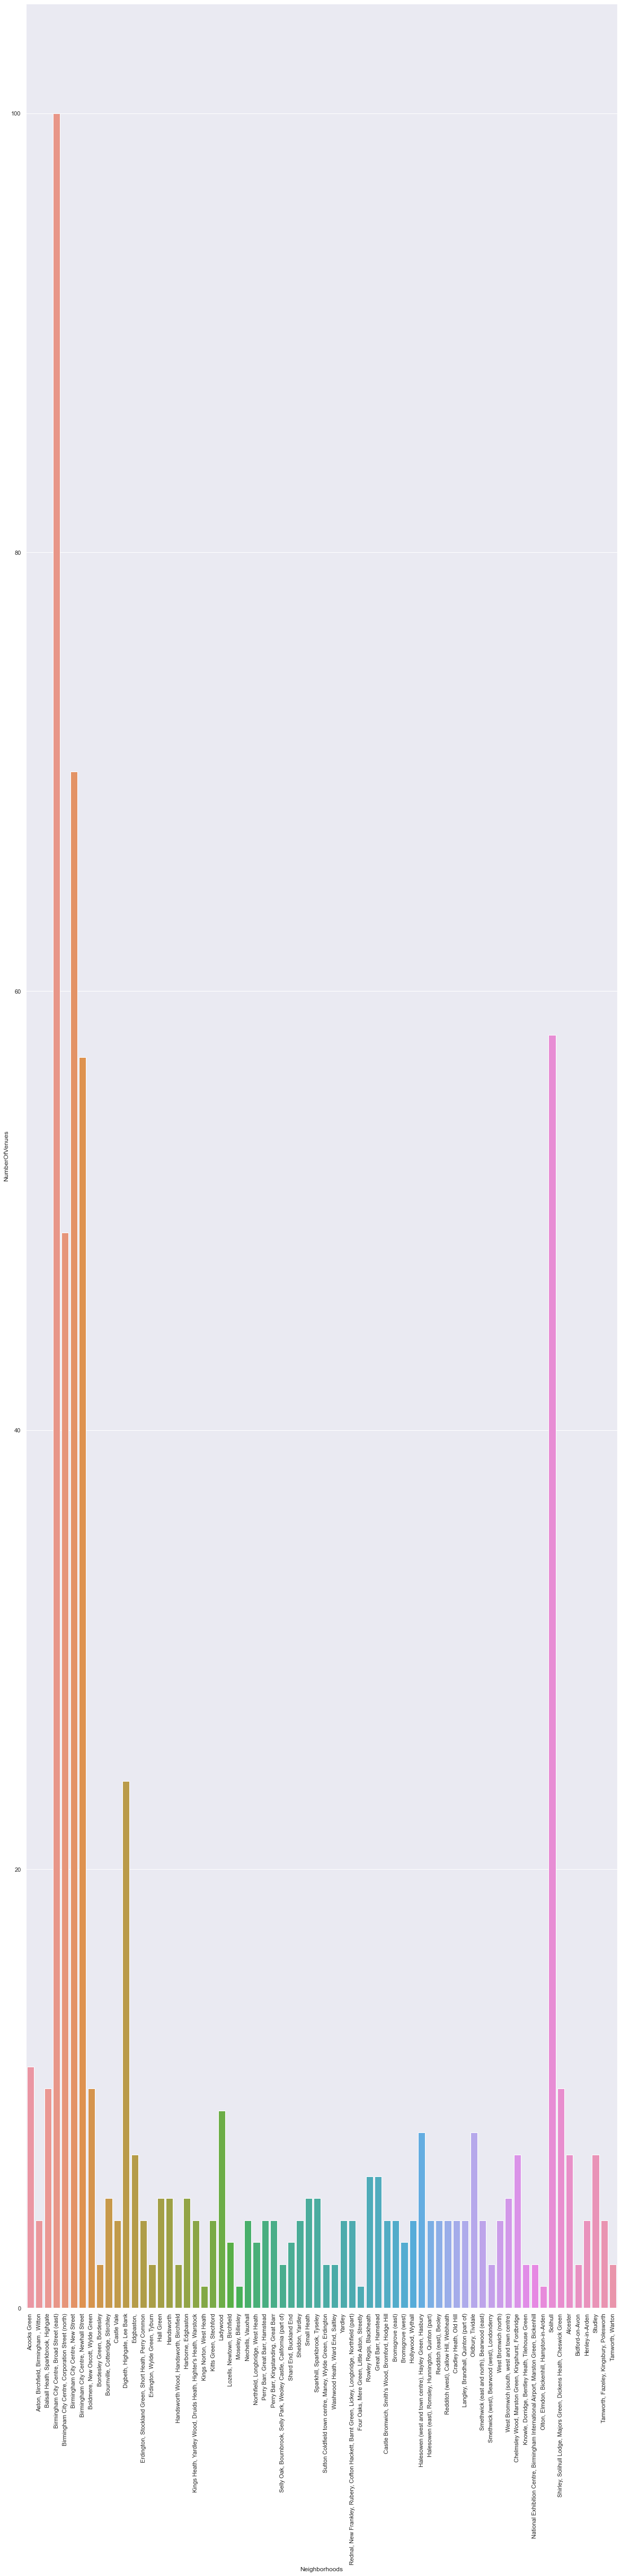

In [278]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,80)})
plot = sns.barplot(x='Neighborhoods',y='NumberOfVenues',data=birmingham_grouped_count)
plot.set_xticklabels(birmingham_grouped_count['Neighborhoods'],rotation=90)

From the above graph we can see that **Birmingham City Centre, Broad Street (east)** has most number of venues and soo on...

## Average Housing Prices In Birmingham to look the cheapest price for Buying a place for an Indian restaurant

In [279]:
Birmingham_Avg_HousingPrice=pd.DataFrame({"Neighborhood":birmingham_merged["Neighborhood"],
                                      "Average_Housing_Price":[2301498.0,7265250.0,1592250.0,4062754.0,628555.0,1006780.0,514910.0,869873.0,
                                                               159916.0,2501492.0,2702695.0,2303597.0,2102994.0,2909299.0,2207191.0,2804893.0,
                                                               2606298.0,2407396.0,7965259.0,7265252.0,7465254.0,7165251.0,7765287.0,7665256.0,
                                                               7365253.0,7565255.0,7065260.0,1292252.0,1592255.0,1792257.0,1492254.0,1992259.0,
                                                               1192251.0,1392253.0,1892258.0,1692256.0,4962759.0,4262752.0,4062750.0,4162751.0,
                                                               4762757.0,4662756.0,4362753.0,4562755.0,4062770.0,658572.0,1206782.0,1506785.0,
                                                               1706787.0,1406784.0,1906789.0,1106781.0,1306783.0,1806788.0,1606790.0,1006770.0,
                                                               594919.0,524912.0,544914.0,574917.0,534913.0,564916.0,504920.0,849881.0,
                                                               129912.0,159915.0,179917.0,149914.0,119911.0,139913.0,189918.0,179920.0,
                                                               169925.0,
                                                                ]})                         

In [280]:
Birmingham_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

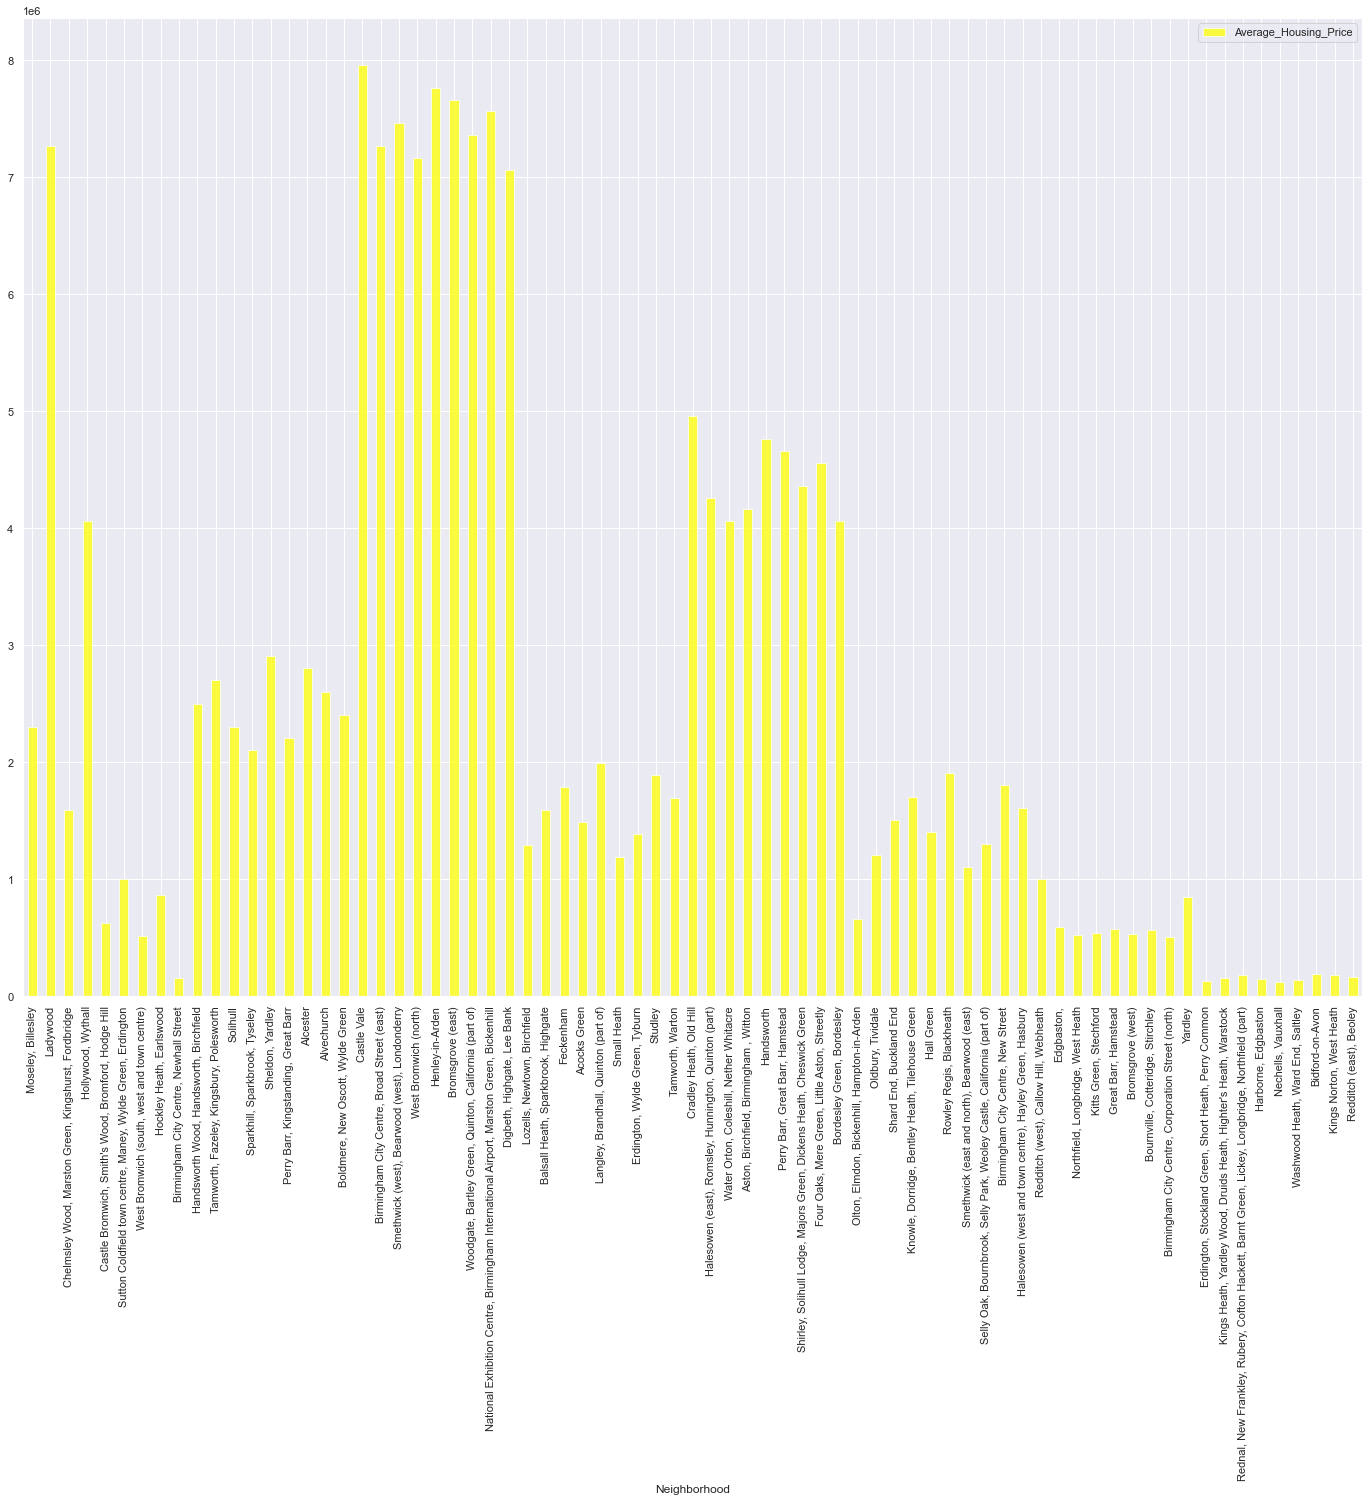

In [281]:
Birmingham_Avg_HousingPrice.plot(kind='bar',figsize=(24,18), color = 'yellow', alpha=0.75)

From above Graph we can see that Places having Postal Code B9 like **Birmingham City Centre, Broad Street (east)**, **Birmingham City Centre, New Street**, **Solihull** have cheapest values and it has highest number of venues.

In [282]:
#https://developer.foursquare.com/docs/resources/categories
#Indian Restaurant = 4bf58dd8d48988d10f941735
neighborhoods = birmingham_merged[birmingham_merged['Borough'] == 'Birmingham'].reset_index(drop=True)
birmingham_venues_indianrestaurant = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['latitude'], longitudes=neighborhoods['longitude'], radius=1000, categoryIds='4bf58dd8d48988d10f941735')
birmingham_venues_indianrestaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Moseley, Billesley",52.43644,-1.8779,Poplar Balti,52.436234,-1.890827,Indian Restaurant
1,"Moseley, Billesley",52.43644,-1.8779,The Minar Balti House,52.443807,-1.878038,Indian Restaurant
2,"Moseley, Billesley",52.43644,-1.8779,D Spice,52.434895,-1.892497,Indian Restaurant
3,"Moseley, Billesley",52.43644,-1.8779,The Spice Merchant,52.436101,-1.891301,Indian Restaurant
4,"Moseley, Billesley",52.43644,-1.8779,Pangea,52.436104,-1.891515,Indian Restaurant


From Above dataframe we can see that **neighborhoods except the above neighborhoods** are the places where we can open an Indian restaurant.

## Discussion <a name="discussion"></a>

The major purpose of this project, is to suggest a better neighborhood in a new city for the person who wants to open a new Indian restaurant. Social presence in society in terms of like minded people. Connectivity to the airport, bus stand, city center, markets and other daily needs things nearby.

* Sorted list of house in terms of housing prices in a ascending or descending order
* Sorted list of places having Indian Restaurant

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Birmingham areas with low number of Indian restaurants in order to aid stakeholders in narrowing down the search for optimal location for an Indian   restaurant.Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decision on optimal Indian restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.